In [1]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import LabelEncoder
import math

In [2]:
CFG = {
    'BATCH_SIZE': 2**12
    , 'EPOCHS': 40
    , 'LEARNING_RATE': 1e-3
    , 'SEED' : 42
    , 'MAX_SEQ_LEN' : 2**9
    , 'MODEL_NAME' : 'lstm_leakyrelu.pth'
    , 'DOWN_SAMPLE_RATE' : 9
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

# Data Pre-processing for Train, Infer

In [4]:
class Storage:
    def __init__(self
                 , path : str = '.'
                 , seed : int = 42
                 , down_sample_rate : int = 2
                ):
        self.path = path
        self.seed = seed
        self.down_sample_rate = down_sample_rate

        # Target / Sequence
        self.target_col = "clicked"
        self.ads_col = 'l_feat_14'
        self.seq_col = "seq"

    def data_pre_process(self):

        train, test = self._load_data()

        train, test, cat_cols, le_dict, num_cols = self._category_sep(train, test)

        self.train = train
        self.test = test
        self.cat_cols = cat_cols
        self.le_dict = le_dict
        self.num_cols = num_cols
        self.max_seq_col = 1000#self.extract_unique_values_batch(self.train[self.seq_col]).astype(int).max()

        self.le_ads_col, self.n_ads_col = self._ads_col_label_encoding()

        self.train = self.cat_to_label(self.train)
        self.train[self.ads_col] = self._get_each_label(self.le_ads_col, self.train[self.ads_col])
        
        self.test = self.cat_to_label(self.test)
        self.test[self.ads_col] = self._get_each_label(self.le_ads_col, self.test[self.ads_col])

        self.add_engineered_feature(is_train_df = True)
        self.add_engineered_feature(is_train_df = False)
        
    def _load_data(self):
        # 데이터 로드
        all_train = pd.read_parquet(self.path + "/train.parquet", engine="pyarrow")
        test = pd.read_parquet(self.path + "/test.parquet", engine="pyarrow").drop(columns=['ID'])
        
        print("Train shape:", all_train.shape)
        print("Test shape:", test.shape)
        
        return self._down_sampling(all_train), test #all_train, test#

    def _category_sep(self, train, test):
        # categorical feature 분리
        cat_cols = {}
        le_dict = {}
        num_cols = []
        for col in train.columns:
            if col == self.target_col or col == self.ads_col or col == self.seq_col:
                continue
            if (train[col].astype(float).fillna(0) % 1 == 0).all():  # 소수점 이하가 전부 0인지 체크 - int 분류
                l = len(train[col].dropna().unique())
                #print(col, l)
                
                if l < 100: # category column 분류
                    le_dict[col] = LabelEncoder()
                    le_dict[col].fit(train[col].dropna()) # 결측치는 Torch DataSet 처리 : 일단 빼기, category 수만 체크
                    cat_cols[col] = len(le_dict[col].classes_)
                else:
                    num_cols.append(col)
                    
            else:
                num_cols.append(col)

        return train, test, cat_cols, le_dict, num_cols

    def _down_sampling(self, train):
        # clicked == 1 데이터
        clicked_1 = train[train['clicked'] == 1]
        
        # clicked == 0 데이터에서 동일 개수x2 만큼 무작위 추출 (다운 샘플링)
        clicked_0 = train[train['clicked'] == 0].sample(n=len(clicked_1)*self.down_sample_rate, random_state=self.seed)
        
        # 두 데이터프레임 합치기
        train = pd.concat([clicked_1, clicked_0], axis=0).sample(frac=1, random_state=self.seed).reset_index(drop=True)

        print("Train shape:", train.shape)
        print("Train clicked:0:", train[train['clicked']==0].shape)
        print("Train clicked:1:", train[train['clicked']==1].shape)

        return train

    def _ads_col_label_encoding(self):
        le_ads_col = LabelEncoder()
        le_ads_col.fit(self.train[self.ads_col].dropna())
        n_ads_col = len(le_ads_col.classes_)
        return le_ads_col, n_ads_col

    def cat_to_label(self, data):
        for col in tqdm(self.le_dict.keys(),  desc='Label Encoding'):
            data[col] = self._get_each_label(self.le_dict[col], data[col])

        return data

    def add_engineered_feature(self, is_train_df = True):
        print(f'get engineered feature : is_train = {is_train_df}')
        if is_train_df:
            data = self.train
        else:
            data = self.test
        tqdm.pandas()
        data[['seq_len', 'seq_unique', 'seq_diversity']] = data['seq'].progress_apply(
            lambda x: pd.Series(self.get_seq_stats(x))
        )


        if is_train_df:
            self.train = data
            for col in ['seq_len', 'seq_unique', 'seq_diversity']:
                self.num_cols.append(col)
        else:
            self.test = data
            

    @staticmethod
    def _get_each_label(le, data_list):
        n = data_list.shape
        label2id = {label: idx + 1 for idx, label in enumerate(le.classes_)}
        data_list = pd.Series(data_list)
        result = data_list.map(label2id).to_numpy()
        
        return result

    #### seq col 처리를 위한 함수
    @staticmethod
    def extract_unique_values(batch):
        # 배치 내 고유값 추출
        unique_values = (
            batch.dropna()
                 .str.split(',')
                 .explode()
                 .unique()
        )
        return unique_values
    
    def extract_unique_values_batch(self, series, batch_size=100000):
        all_uniques = set()
        
        for start in tqdm(range(0, len(series), batch_size), desc='Extract Unique Values from Sequence Columns'):
            end = start + batch_size
            batch = series[start:end]
            unique_values = self.extract_unique_values(batch)
            all_uniques.update(unique_values)
    
        # 최종 유니크한 값 정렬된 리스트로 반환
        return np.array(sorted(all_uniques))
    @staticmethod
    def get_seq_stats(seq_str):
        if not seq_str:
            return 0.0, 0.0, 0.0
        tokens = seq_str.split(',')
        length = len(tokens)
        unique_cnt = len(set(tokens))
        diversity = unique_cnt / length if length > 0 else 0.0
        return length/100, unique_cnt/10, diversity

In [5]:
storage = Storage(path = '.'
                  , seed = CFG['SEED']
                  , down_sample_rate = CFG['DOWN_SAMPLE_RATE']
)

In [6]:
storage.data_pre_process()

Train shape: (10704179, 119)
Test shape: (1527298, 118)
Train shape: (2041790, 119)
Train clicked:0: (1837611, 119)
Train clicked:1: (204179, 119)


Label Encoding: 100%|██████████| 23/23 [00:00<00:00, 26.68it/s]


get engineered feature : is_train = True


100%|██████████| 2041790/2041790 [03:56<00:00, 8647.77it/s] 


get engineered feature : is_train = False


100%|██████████| 1527298/1527298 [02:53<00:00, 8798.13it/s] 


In [7]:
# Target / Sequence

print("Num categorical features:", len(storage.cat_cols))
print("Num numerical features:", len(storage.num_cols))
print("Target Ads:", storage.ads_col)
print("Sequence:", storage.seq_col)
print("Target:", storage.target_col)

Num categorical features: 23
Num numerical features: 96
Target Ads: l_feat_14
Sequence: seq
Target: clicked


# Define Custom Dataset

In [8]:
class ClickDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, ads_col, seq_col, max_seq_len, target_col=None, has_target=True):
        self.df = df.reset_index(drop=True)
        self.cat_cols = list(cat_cols.keys())
        self.num_cols = num_cols
        self.ads_col = ads_col
        self.seq_col = seq_col
        self.target_col = target_col
        self.has_target = has_target
        self.max_seq_len = max_seq_len

        # 비-시퀀스 피처: category - int, num - float
        self.cats = self.df[self.cat_cols].astype(float).fillna(0).astype(int).values
        self.nums = self.df[self.num_cols].astype(float).fillna(0).values
        self.ads = self.df[self.ads_col].astype(float).fillna(0).astype(int).values

        # 시퀀스: 문자열 그대로 보관 (lazy 파싱)
        self.seq_strings = self.df[self.seq_col].astype(str).values

        if self.has_target:
            self.y = self.df[self.target_col].astype(np.float32).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cats = torch.tensor(self.cats[idx], dtype=torch.int)
        nums = torch.tensor(self.nums[idx], dtype=torch.float)
        ads = torch.tensor(self.ads[idx], dtype=torch.int).unsqueeze(dim=0)

        # 전체 시퀀스 사용 (빈 시퀀스만 방어)
        s = self.seq_strings[idx]
        if s:
            ## seq len 제한
            arr = np.fromstring(s, sep=",", dtype=np.float32)[-self.max_seq_len:] # 2000개 초과 비율 약 0.5%, 클릭율 1.8%로 전체(1.9%)보다 낮음
        else:
            arr = np.array([], dtype=np.float32)

        if arr.size == 0:
            arr = np.array([0.0], dtype=np.float32)  # 빈 시퀀스 방어

        seq = torch.from_numpy(arr)  # shape (seq_len,)

        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float)
            return cats, nums, ads, seq, y
        else:
            return cats, nums, ads, seq

In [9]:
def collate_fn_train(batch):
    cats, nums, ads, seqs, ys = zip(*batch)
    cats = torch.stack(cats)
    nums = torch.stack(nums)
    ads = torch.stack(ads)
    ys = torch.stack(ys)
    seqs_padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)  # 빈 시퀀스 방지
    return cats, nums, ads, seqs_padded.to(torch.int32), seq_lengths, ys

def collate_fn_infer(batch):
    cats, nums, ads, seqs = zip(*batch)
    cats = torch.stack(cats)
    nums = torch.stack(nums)
    ads = torch.stack(ads)
    seqs_padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)
    return cats, nums, ads, seqs_padded.to(torch.int32), seq_lengths

# Define Model Architecture


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [T, D]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [T, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [D/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even
        pe[:, 1::2] = torch.cos(position * div_term)  # odd
        pe = pe.unsqueeze(0)  # [1, T, D]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: [B, T, D]
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads=4, num_layers=2, dim_feedforward=128, dropout=0.1, max_len=1000):
        super().__init__()
        self.pos_encoder = PositionalEncoding(emb_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important: [B, T, D]
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, key_padding_mask=None):
        """
        x: [B, T, D]
        key_padding_mask: [B, T] with True for PAD positions
        """
        x = self.pos_encoder(x)
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)  # [B, T, D]
        return x

class TargetAdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super().__init__()
        self.attn_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.attn_score = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, seq_out, target, mask=None):
        """
        seq_out: [B, T, H]
        target: [B, H]
        mask: [B, T] (optional) - True for valid positions
        """
        B, T, H = seq_out.size()
        
        # Expand target embedding to match sequence length
        query_expanded = target.unsqueeze(1).expand(-1, T, -1)  # [B, T, H]
        
        # Concatenate LSTM output and target embedding
        concat = torch.cat([seq_out, query_expanded], dim=-1)  # [B, T, 2H]
        
        # Feed through MLP to get attention score
        attn_hidden = torch.tanh(self.attn_layer(concat))   # [B, T, H]
        attn_hidden = self.dropout(attn_hidden)  
        scores = self.attn_score(attn_hidden).squeeze(-1)   # [B, T]
        
        # Masking (optional)
        if mask is not None:
            scores = scores.masked_fill(~mask, float('-inf'))  # mask False = pad

        # Attention weights
        weights = F.softmax(scores, dim=1)  # [B, T]

        # Weighted sum of LSTM outputs
        context = torch.bmm(weights.unsqueeze(1), seq_out).squeeze(1)  # [B, H]
        
        return context, weights
        
class GRULayerBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, dropout=0.0, batch_first=True, max_seq_len=2**10):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.gru = nn.GRU(input_size=input_size
                          , hidden_size=hidden_size
                          , num_layers=num_layers
                          , bidirectional=bidirectional
                          , dropout=dropout
                          , batch_first=batch_first
                         )

    def forward(self, x, lengths=None):
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, h_n = self.gru(packed)
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=self.max_seq_len)  # [B, T, H]
        else:
            output, h_n = self.gru(x)  # no packing

        # c_n은 LSTM에서만 존재하므로 None으로 리턴
        return output, (h_n, None)

class LSTMLayerBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, dropout=0.0, batch_first=True, max_seq_len=2**10):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.lstm = nn.LSTM(input_size=input_size
                            , hidden_size=hidden_size
                            , num_layers=num_layers
                            , bidirectional=bidirectional
                            , dropout=dropout
                            , batch_first=batch_first
                           )

    def forward(self, x, lengths=None):
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, (h_n, c_n) = self.lstm(packed)
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=self.max_seq_len)  # [B, T, H]
        else:
            output, (h_n, c_n) = self.lstm(x)  # no packing
            
        return output, (h_n, c_n)
        
class ExponentialCrossNetwork(nn.Module):
    def __init__(self, input_dim, num_layers=2, dropout = 0.2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, input_dim),
                nn.Dropout(dropout)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        out = x
        for l, layer in enumerate(self.layers, start=1):
            mask = torch.sigmoid(layer(out))  # Self-Mask 기능
            out = x.pow(2**(l-1)) * mask
        return out
        
class GatedCrossLayerBlock(nn.Module):
    def __init__(self
                 , input_dim : int
                 , num_layers : int
                 , dropout : float = 0.2
                 , gate_function = nn.Sigmoid()
                ):
        # input_dim : embedding_vector_dim * number of feature?
        super(GatedCrossLayerBlock, self).__init__()
        input_dim = input_dim
        self.num_layers = num_layers
        self.gate_function = gate_function
        
        self.wc = nn.ModuleList() # weight of cross layer
        self.wg = nn.ModuleList() # weight of gate layer
        self.bias = nn.ParameterList() # bias
        for _ in range(self.num_layers):
            self.wc.append(
                nn.Sequential(nn.Linear(input_dim, input_dim), nn.Dropout(dropout))
            )
            self.wg.append(
                nn.Sequential(nn.Linear(input_dim, input_dim), nn.Dropout(dropout))
            )
            self.bias.append(nn.Parameter(torch.zeros(input_dim)))
            
        for m in self.wg.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                

    def forward(self, x):
        # cross networking
        '''
        c_(l+1) = c0*(wc_l + bias_l) * gated(wg_l) + c_l
        
        wc_l : nn.linear(c_l)
        wg_l : nn.linear(c_l)
        '''
        x0 = x
        for i in range(self.num_layers):
            xc = self.wc[i](x)
            xg = self.gate_function(self.wg[i](x))

            x = x0*(xc+self.bias[i])*xg + x

        return x # [batch_size, input_dim]
        
class DNNLyaer(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout = 0.2):
        super().__init__()
        layers = []
        nag_slope = 0.01
        for h in hidden_dims:
            linear = nn.Linear(input_dim, h)
            nn.init.kaiming_normal_(linear.weight, a=nag_slope, nonlinearity='leaky_relu')
            nn.init.zeros_(linear.bias)
        
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.LeakyReLU(negative_slope=nag_slope))
            layers.append(nn.Dropout(dropout))
            input_dim = h
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class Wide(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim*3, 1)

    def forward(self, x):
        x = torch.cat([x
                       , x**2
                       #, torch.log(torch.clamp(x,min=1e-6))
                       , x**3
                      ], dim=1)
        return self.linear(x)  # (B, 1)
        
class FMLayer(nn.Module):
    def forward(self, x):
        square_of_sum = torch.pow(x.sum(dim=1), 2)
        sum_of_square = (x * x).sum(dim=1)
        return (0.5 * (square_of_sum - sum_of_square)).unsqueeze(1)  # [batch_size, 1]

        
class TabularSeqModel(nn.Module):
    def __init__(self
                 , cat_cols
                 , num_cols
                 , n_ads_col
                 , max_seq_col
                 , max_seq_len
                 , seq_emb_dim=32
                 , feature_emb_dim = 8
                 , num_layers = 4
                 , mlp_hidden_units=[1024, 512, 256, 128]
                 , dropout=0.2
                ):
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # categorical feature part
        n_cats = len(cat_cols)
        self.cat_embs = nn.ModuleList([
            nn.Embedding(num_categories+1, feature_emb_dim, padding_idx=0)
            for num_categories in cat_cols.values()
        ])
        
        # numerical feature part
        n_cols = len(num_cols)
        self.num_proj = nn.BatchNorm1d(n_cols)#ProjectionLayer(n_cols, feature_emb_dim)

        # ads column part
        self.ads_emb = nn.Embedding(n_ads_col+1, seq_emb_dim, padding_idx = 0)

        ## sequantial layer block
        # seq: 숫자 시퀀스 → LSTM
        self.seq_emb = nn.Embedding(max_seq_col+1, seq_emb_dim, padding_idx=0)
        self.seq_module = LSTMLayerBlock(input_size=seq_emb_dim
                                         , hidden_size=seq_emb_dim
                                         , num_layers=min(2,num_layers)
                                         , batch_first=True
                                         , dropout=min(0.3,dropout)
                                         , max_seq_len=max_seq_len
                                        )#GRULayerBlock

        # attention with ads set
        attn_output_dim = seq_emb_dim
        self.attn = TargetAdditiveAttention(hidden_dim = seq_emb_dim, dropout=min(0.2,dropout))

        ## feature train layer blocks
        # Wide Layer Block - 1차원
        wd_input_dim = n_cats*feature_emb_dim + n_cols + seq_emb_dim + seq_emb_dim + seq_emb_dim
        wd_output_dim = 1
        self.wide = Wide(input_dim=wd_input_dim)
        print(f'model wide_dim : {wd_input_dim}, output_dim : {wd_output_dim}')
        
        # FM Layer Block - 저차원
        fm_input_dim = n_cats*feature_emb_dim + n_cols + seq_emb_dim + seq_emb_dim + seq_emb_dim
        fm_output_dim = 1
        self.fm = FMLayer()
        print(f'model fm_dim : {fm_input_dim}, output_dim : {fm_output_dim}')

        # Gated Cross Layer Block - 저차원 선택적 학습
        gcn_output_dim = gcn_input_dim = n_cats*feature_emb_dim + n_cols + seq_emb_dim + seq_emb_dim + seq_emb_dim # ads_col, seq_col, attn 3개
        self.gcn = GatedCrossLayerBlock(input_dim=gcn_input_dim, num_layers=num_layers, dropout = dropout)
        print(f'model gcn_dim : {gcn_input_dim}')

        # Exponential Cross Layer Block - 고차원 선택적 학습
        ecn_output_dim = ecn_input_dim = n_cats*feature_emb_dim + n_cols + seq_emb_dim + seq_emb_dim + seq_emb_dim
        self.ecn = ExponentialCrossNetwork(input_dim = ecn_input_dim, num_layers=min(3,num_layers), dropout = dropout) # 크면 터짐
        print(f'model ecn_dim : {ecn_input_dim}')

        # DNN Layer Block - 고차원
        dnn_output_dim = dnn_input_dim = n_cats*feature_emb_dim + n_cols + seq_emb_dim + seq_emb_dim + seq_emb_dim
        self.dnn = DNNLyaer(input_dim = dnn_input_dim, hidden_dims = [dnn_input_dim for _ in range(num_layers)], dropout = dropout)
        print(f'model dnn_dim : {dnn_input_dim}')
        
        ## 최종 MLP
        final_input_dim = wd_output_dim + fm_output_dim + gcn_output_dim + ecn_output_dim + dnn_output_dim # 
        print(f'model final_input_dim : {final_input_dim}')
        layers = []
        nag_slope = 0.1
        for h in mlp_hidden_units:
            linear = nn.Linear(final_input_dim, h)
            nn.init.kaiming_normal_(linear.weight, a=nag_slope, nonlinearity='leaky_relu')
            #nn.init.xavier_normal_(linear.weight)
            nn.init.zeros_(linear.bias)
            
            layers += [linear, nn.BatchNorm1d(h), nn.LeakyReLU(negative_slope=nag_slope), nn.Dropout(dropout)]
            final_input_dim = h

        final_linear = nn.Linear(final_input_dim, 1)
        nn.init.xavier_normal_(final_linear.weight)
        nn.init.zeros_(final_linear.bias)
        
        layers += [final_linear, nn.Sigmoid()]
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_cats, x_nums, x_ads, x_seq, seq_lengths):
        # categorical feature part
        embedded_cats = [
            emb(x_cats[:, i])  # shape: (batch_size, embedding_dim)
            for i, emb in enumerate(self.cat_embs)
        ]
        embedded_cats = torch.cat(embedded_cats, dim=1) # (B, n_cats*emb_dim)

        # numerical feature part
        embedded_nums = self.num_proj(x_nums) # (B, n_nums), BatchNormalize

        # ads set part
        embedded_ads = self.ads_emb(x_ads)
        embedded_ads = embedded_ads.squeeze(1)

        # concat
        x = torch.cat([embedded_cats, embedded_nums, embedded_ads], dim=1) # (B, n_cats*feature_emb_dim + bn_cols)
        
        # 시퀀스 → GRU
        x_seq = self.seq_emb(x_seq)  # (B, L, seq_emb)
        seq_out, (h_n, c_n) = self.seq_module(x_seq, seq_lengths)
        h = h_n[-1]    # (B,emb_dim)
        mask = torch.arange(seq_out.size(1)).unsqueeze(0).to(self.device) < seq_lengths.unsqueeze(1)
        attn_output, attn_weights = self.attn(seq_out, embedded_ads, mask=mask)
        

        z = torch.cat([x, h, attn_output], dim=1) # (B, n_cats*feature_emb_dim + bn_cols + seq_emb_dim)

        # Wide LayerBlock
        z_wd = self.wide(z)
        # FM LayerBlock
        z_fm = self.fm(z)
        # GC LayerBlock
        z_gc = self.gcn(z)
        # EC LayerBlock
        z_ec = self.ecn(z)
        # DNN LayerBLock
        z_dnn = self.dnn(z)
        
        z = torch.cat([z_wd
                       ,z_fm
                       ,z_gc
                       ,z_ec
                       ,z_dnn], dim=1)
        
        return self.mlp(z).squeeze(1)  # logits

# Train / Validation


In [11]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.metrics import average_precision_score


class WeightedBCELoss(nn.Module):
    def __init__(self, weight = [1,1]):
        super().__init__()

        self.w0 = weight[0]/sum(weight)
        self.w1 = weight[1]/sum(weight)

    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        y_pred = y_pred.float()

        N0 = (y_true == 0).sum()
        N1 = (y_true == 1).sum()

        w0 = self.w0 / N0
        w1 = self.w1 / N1

        sample_weights = torch.where(y_true == 0, w0, w1)
        bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        weighted_loss = (bce_loss * sample_weights).sum()
        
        return weighted_loss

class Trainer:
    def __init__(self
                 , model = None
                 , loss_func = nn.BCELoss()
                ):
        self.model = model
        self.loss_func = loss_func
        
    def fit(self
            , train_df
            , cat_cols : dict
            , num_cols : list
            , ads_col : str
            , seq_col : str
            , max_seq_len : int
            , target_col : str
            , batch_size : int = 512
            , epochs : int = 3
            , learning_rate : float = 1e-3
            , device : str = None
            , model_name : str = 'model.pth'
           ):
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        #self.device = 'cpu'
        self.model.to(self.device)
        print(f'training with {self.device}')
        # 1) split
        tr_df, va_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
    
        # 2) Dataset / Loader
        train_dataset = ClickDataset(tr_df, cat_cols, num_cols, ads_col, seq_col, max_seq_len, target_col, has_target=True)
        eval_dataset   = ClickDataset(va_df, cat_cols, num_cols, ads_col, seq_col, max_seq_len, target_col, has_target=True)
    
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn_train)
        eval_loader   = DataLoader(eval_dataset, batch_size=batch_size//4, shuffle=False, collate_fn=collate_fn_train)

        # 2-1) optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=epochs, T_mult=1)
        
        # 3) Loop
        self.last_loss = 0
        early_stop_count = 0
        for epoch in range(1, epochs+1):
            train_loss = self._batch_process(train_loader, is_train = True)
            print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}")
            
            with torch.no_grad():
                eval_loss = self._batch_process(eval_loader, is_train = False)
            
            current_lr = self.scheduler.get_last_lr()
            
            if self.last_loss < eval_loss:
                early_stop_count = 0
                self.last_loss = eval_loss
                torch.save(model.state_dict(), model_name)
            else:
                early_stop_count += 1
                    
            print(f"[Epoch {epoch}] Train Loss: {train_loss:.6f} | Val Loss: {eval_loss:.6f} | Learning Rate : {current_lr} | stopping_count : {early_stop_count}")
            if early_stop_count >= 3:
                break

        print(f'last score : {self.last_loss}')
    
        return model

    def _batch_process(self, loader, is_train : bool = True):
        if is_train:
            self.model.train()
            mode = 'Train'
        else:
            self.model.eval()
            mode = 'Eval'
        torch.cuda.empty_cache()
        losses = [] # eval mode에서 preds 겸용
        nums = [] # eval mode에서 trues 겸용
        for xcats, xnums, ads, seqs, seq_lens, ys in tqdm(loader, desc=mode):
            xcats, xnums, ads, seqs, seq_lens, ys = xcats.to(self.device), xnums.to(self.device), ads.to(self.device), seqs.to(self.device), seq_lens.to(self.device), ys.to(self.device)
            logits = self.model(xcats, xnums, ads, seqs, seq_lens)
            if is_train:
                loss, num = self._get_loss(logits, ys, is_train)
                losses.append(loss)
                nums.append(num)
            else:
                losses.append(logits.detach().cpu())
                nums.append(ys.detach().cpu())

        if is_train:
            total_loss = sum([x*y for x,y in zip(losses, nums)])
            total_loss = total_loss/sum(nums)
        else:
            all_preds = torch.cat(losses).view(-1)
            all_trues = torch.cat(nums).view(-1)

            total_loss = 0.5 * average_precision_score(all_trues.numpy(), all_preds.numpy()) + 0.5 * 1/(1+WeightedBCELoss()(all_preds, all_trues).item())

        
        return total_loss


    def _get_loss(self, preds, labels, is_train : bool):
        
        loss = self.loss_func(preds,labels)
        if is_train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
        return loss.item(), preds.shape[0]

# Run!!


In [12]:
seed_everything(CFG['SEED']) # Seed 고정

# 3) 모델
model_args = {'cat_cols' : storage.cat_cols
              , 'num_cols' : storage.num_cols
              , 'n_ads_col' : storage.n_ads_col
              , 'max_seq_col' : storage.max_seq_col
              , 'max_seq_len' : CFG['MAX_SEQ_LEN']
              , 'seq_emb_dim' : 2**5
              , 'feature_emb_dim' : 2**3
              , 'num_layers' : 5
              , 'mlp_hidden_units' : [512,128]
              , 'dropout' : 0.4}

model = TabularSeqModel(**model_args)

criterion = WeightedBCELoss()

trainer = Trainer(model, loss_func = criterion)


print(CFG)
trainer.fit(
    train_df=storage.train,
    cat_cols = storage.cat_cols,
    num_cols = storage.num_cols,
    ads_col = storage.ads_col,
    seq_col = storage.seq_col,
    max_seq_len = CFG['MAX_SEQ_LEN'],
    target_col=storage.target_col,
    batch_size=CFG['BATCH_SIZE'],
    epochs=CFG['EPOCHS'],
    learning_rate=CFG['LEARNING_RATE'],
    model_name = CFG['MODEL_NAME']
)
torch.cuda.empty_cache()

model wide_dim : 376, output_dim : 1
model fm_dim : 376, output_dim : 1
model gcn_dim : 376
model ecn_dim : 376
model dnn_dim : 376
model final_input_dim : 1130
{'BATCH_SIZE': 4096, 'EPOCHS': 40, 'LEARNING_RATE': 0.001, 'SEED': 42, 'MAX_SEQ_LEN': 512, 'MODEL_NAME': 'lstm_leakyrelu.pth', 'DOWN_SAMPLE_RATE': 9}
training with cuda


Train: 100%|██████████| 399/399 [22:49<00:00,  3.43s/it]


[Epoch 1] Train Loss: 0.6775


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.97it/s]


[Epoch 1] Train Loss: 0.677461 | Val Loss: 0.437038 | Learning Rate : [1.541333133436018e-06] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:54<00:00,  3.44s/it]


[Epoch 2] Train Loss: 0.6353


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.89it/s]


[Epoch 2] Train Loss: 0.635286 | Val Loss: 0.441971 | Learning Rate : [6.15582970243117e-06] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 3] Train Loss: 0.6224


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.99it/s]


[Epoch 3] Train Loss: 0.622421 | Val Loss: 0.446954 | Learning Rate : [1.3815039801161721e-05] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:53<00:00,  3.44s/it]


[Epoch 4] Train Loss: 0.6152


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.94it/s]


[Epoch 4] Train Loss: 0.615182 | Val Loss: 0.449763 | Learning Rate : [2.4471741852423235e-05] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:53<00:00,  3.44s/it]


[Epoch 5] Train Loss: 0.6106


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.93it/s]


[Epoch 5] Train Loss: 0.610611 | Val Loss: 0.450587 | Learning Rate : [3.806023374435663e-05] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 6] Train Loss: 0.6064


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.97it/s]


[Epoch 6] Train Loss: 0.606361 | Val Loss: 0.452663 | Learning Rate : [5.449673790581611e-05] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:54<00:00,  3.44s/it]


[Epoch 7] Train Loss: 0.6043


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.96it/s]


[Epoch 7] Train Loss: 0.604307 | Val Loss: 0.452310 | Learning Rate : [7.367991782295391e-05] | stopping_count : 1


Train: 100%|██████████| 399/399 [22:54<00:00,  3.44s/it]


[Epoch 8] Train Loss: 0.6024


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.93it/s]


[Epoch 8] Train Loss: 0.602415 | Val Loss: 0.453695 | Learning Rate : [9.549150281252633e-05] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:54<00:00,  3.44s/it]


[Epoch 9] Train Loss: 0.6009


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.92it/s]


[Epoch 9] Train Loss: 0.600875 | Val Loss: 0.454729 | Learning Rate : [0.00011979701719998454] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 10] Train Loss: 0.5992


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.93it/s]


[Epoch 10] Train Loss: 0.599189 | Val Loss: 0.454779 | Learning Rate : [0.00014644660940672628] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 11] Train Loss: 0.5969


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.97it/s]


[Epoch 11] Train Loss: 0.596868 | Val Loss: 0.455555 | Learning Rate : [0.00017527597583490823] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 12] Train Loss: 0.5954


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.89it/s]


[Epoch 12] Train Loss: 0.595372 | Val Loss: 0.456421 | Learning Rate : [0.00020610737385376348] | stopping_count : 0


Train: 100%|██████████| 399/399 [22:55<00:00,  3.45s/it]


[Epoch 13] Train Loss: 0.5934


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.91it/s]


[Epoch 13] Train Loss: 0.593429 | Val Loss: 0.456282 | Learning Rate : [0.00023875071764202561] | stopping_count : 1


Train: 100%|██████████| 399/399 [22:54<00:00,  3.45s/it]


[Epoch 14] Train Loss: 0.5923


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.91it/s]


[Epoch 14] Train Loss: 0.592334 | Val Loss: 0.454066 | Learning Rate : [0.00027300475013022663] | stopping_count : 2


Train: 100%|██████████| 399/399 [22:52<00:00,  3.44s/it]


[Epoch 15] Train Loss: 0.5905


Eval: 100%|██████████| 399/399 [00:57<00:00,  6.88it/s]


[Epoch 15] Train Loss: 0.590530 | Val Loss: 0.455716 | Learning Rate : [0.0003086582838174551] | stopping_count : 3
last score : 0.4564208939349199


# Inference

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Dataset/Loader
test_ds = ClickDataset(storage.test, storage.cat_cols, storage.num_cols, storage.ads_col, storage.seq_col, CFG['MAX_SEQ_LEN'], storage.target_col, has_target=False)
test_ld = DataLoader(test_ds, batch_size=CFG['BATCH_SIZE']//4, shuffle=False, collate_fn=collate_fn_infer)

# 2) Predict
model = TabularSeqModel(**model_args)
model.load_state_dict(torch.load(CFG['MODEL_NAME']))
model.to(device)
model.eval()
outs = []
with torch.no_grad():
    for xcats, xnums, ads, seqs, seq_lens in tqdm(test_ld, desc="Inference"):
        xcats, xnums, ads, seqs, seq_lens = xcats.to(device), xnums.to(device), ads.to(device), seqs.to(device), seq_lens.to(device)
        outs.append(model(xcats, xnums, ads, seqs, seq_lens).cpu())

test_preds = torch.cat(outs).numpy()

model wide_dim : 376, output_dim : 1
model fm_dim : 376, output_dim : 1
model gcn_dim : 376
model ecn_dim : 376
model dnn_dim : 376
model final_input_dim : 1130


Inference: 100%|██████████| 1492/1492 [03:26<00:00,  7.22it/s]


# Submission

In [14]:
submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = test_preds

file_name = CFG['MODEL_NAME'].split('.')[0]
submit.to_csv(f'./{file_name}.csv', index=False)

<Axes: >

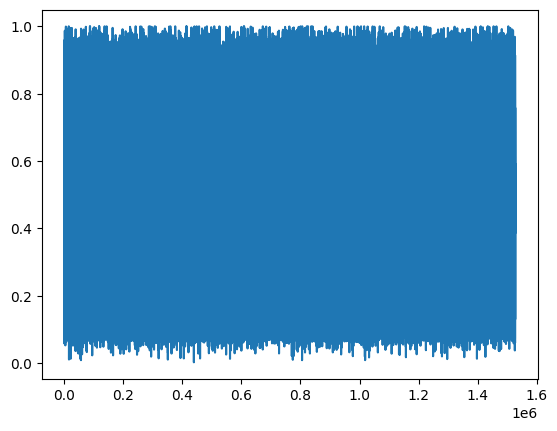

In [15]:
pd.read_csv(f'./{file_name}.csv')['clicked'].plot()